In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
matplotlib.rcParams['pdf.fonttype'] = 42

# df of interactions
df_interactions = pd.read_csv("/home/mouren/Data/interaction/bilan_all_interactions.csv", sep="\t", header=0,index_col=0)

In [2]:
dic_result = {}
content_sig = []
directory = "/home/mouren/Data/variants/tcga_MC3/deseq2_hg19"
for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        with open(os.path.join(directory, filename)) as file:
            first = True
            for line in file:
                if first:
                    first = False
                    continue

                try:
                    split_list = [int(x) for x in df_interactions.at[line.strip().split()[9],line.strip().split()[1]].split(",")] 
                    if split_list.count(1) < 2: #keep target with robust interactions 
                        continue
                except KeyError:
                    continue
                
                if filename.split("_")[0] not in dic_result:
                    dic_result[filename.split("_")[0]] = []

                if "allall" in filename:
                    dic_result[filename.split("_")[0]].append([float(line.strip().split()[3]),float(line.strip().split()[8]),"All", line.strip().split()[9], line.strip().split()[1]])
                    content_sig.append(["all", filename.split("_")[0], line.strip().split()[9],line.strip().split()[1]])
                else:
                    dic_result[filename.split("_")[0]].append([float(line.strip().split()[3]),float(line.strip().split()[8]),"Synonymous", line.strip().split()[9], line.strip().split()[1]])
                    content_sig.append(["syn", filename.split("_")[0], line.strip().split()[9],line.strip().split()[10],line.strip().split()[1]])

df_content_sig = pd.DataFrame(content_sig)

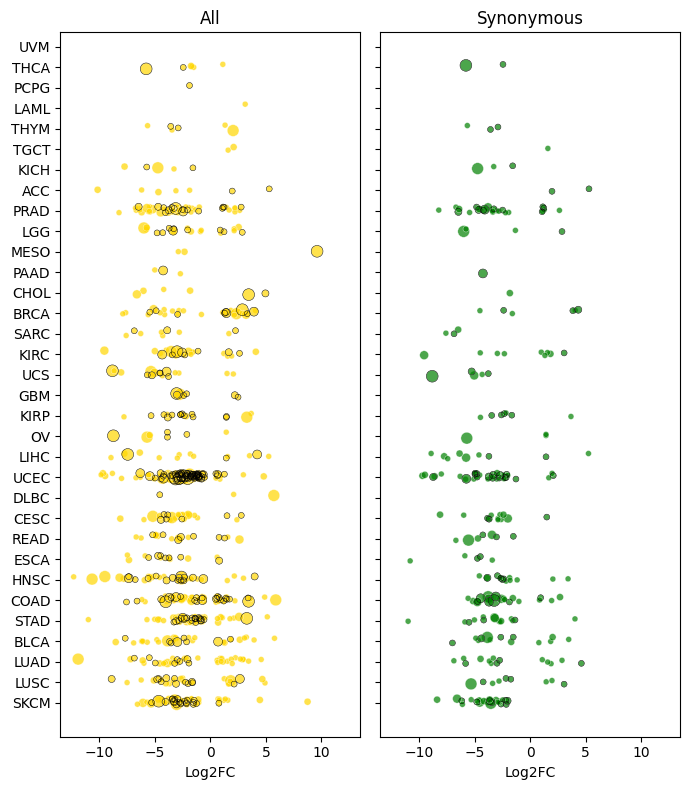

In [ ]:
### SPLITTED
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

dic_gene = {}
with open("dic_gene_ee_hg38.tsv") as file:
    for line in file:    
        dic_gene[line.strip().split()[0]] = line.strip().split()[1]

color_mapping = {
    'Synonymous': 'green',
    'All': 'gold'
}

def map_size(nlog10_pvalue):
    """if nlog10_pvalue <= 1.3:
        return 20  # Smallest size"""
    if  1.3 <= nlog10_pvalue <= 2.3:
        return 20
    elif 2.3 < nlog10_pvalue <= 3.3:
        return 40
    elif 3.3 < nlog10_pvalue <= 4.3:
        return 80
    else:
        return 160  # Largest size
    
plot_data = []
for key, values in dic_result.items():
    for value in values:#log2fc,  nlog10_pvalue, categories intern_or_not
        if dic_gene[value[3]] == value[-1]:
            plot_data.append([key, value[0], map_size(value[1]), color_mapping[value[2]], True]) #cancer, log2fc,  size based on nlog10_pvalue, color based on categories, if target gene is ee host gene 
        else:
            plot_data.append([key, value[0], map_size(value[1]), color_mapping[value[2]], False])

#UVM has zero data so we had an entry just so the x ticks settles themseleves correctly
plot_data.append(["UVM",0,0,"white",False])

df_plot = pd.DataFrame(columns=["Category","Log2FC","Size","Color","Intern"],data=plot_data)


# Make "Category" a proper categorical in the desired order
cat_order = [
    'UVM', 'THCA', 'PCPG', 'LAML', 'THYM', 'TGCT', 'KICH', 'ACC', 'PRAD',
    'LGG', 'MESO', 'PAAD', 'CHOL', 'BRCA', 'SARC', 'KIRC', 'UCS', 'GBM',
    'KIRP', 'OV', 'LIHC', 'UCEC', 'DLBC', 'CESC', 'READ', 'ESCA', 'HNSC',
    'COAD', 'STAD', 'BLCA', 'LUAD', 'LUSC', 'SKCM'
]
df_plot["Category"] = pd.Categorical(df_plot["Category"], cat_order)
df_plot = df_plot.sort_values("Category")
color_list = df_plot.pop("Color")

df_plot["Category_idx"] = df_plot["Category"].cat.codes  # 0,1,2,... for each category

# --- add random jitter around those integers ---
ncat = len(cat_order)
df_plot["Category_rev_code"] = ncat - 1 - df_plot["Category"].cat.codes

np.random.seed(40)  # for reproducibility (optional)
df_plot["Category_jitter"] = (
    df_plot["Category_rev_code"]
    + (np.random.random(len(df_plot)) - 0.3) * 0.3
)

# Subset the data by color (Synonymous=green, All=gold)
df_syn = df_plot[color_list == 'green']
df_all = df_plot[color_list == 'gold']

# Create a figure with two vertical panels side by side
fig, (ax_left, ax_right) = plt.subplots(ncols=2, sharey=True, figsize=(7, 8))
df_intern_all = df_all[df_all['Intern']]
df_intern_syn = df_syn[df_syn['Intern']]


# --- LEFT PANEL (Synonymous, green) ---
sns.scatterplot(
    data=df_all,
    x='Log2FC', 
    y='Category_jitter',  # put categories on the y-axis
    size='Size',
    alpha=0.7,
    color='gold',
    edgecolor='white',
    ax=ax_left,
    legend=False
)

# Overlay the ring for 'Intern' == True
sns.scatterplot(
    data=df_intern_all,
    x='Log2FC', 
    y='Category_jitter',
    size='Size',
    alpha=1,
    facecolors='none',
    edgecolor='black',
    ax=ax_left,
    legend=False
)

ax_left.set_title('All')
ax_left.set_xlabel('Log2FC')

# --- RIGHT PANEL (All, gold) ---
sns.scatterplot(
    data=df_syn,
    x='Log2FC', 
    y='Category_jitter',  # same y so we can share that axis
    size='Size',
    alpha=0.7,
    color='green',
    edgecolor='white',
    ax=ax_right,
    legend=False
)

# Overlay the ring for 'Intern' == True
sns.scatterplot(
    data=df_intern_syn,
    x='Log2FC', 
    y='Category_jitter',
    size='Size',
    alpha=1,
    facecolors='none',
    edgecolor='black',
    ax=ax_right,
    legend=False
)

ax_right.set_title('Synonymous')
ax_right.set_xlabel('Log2FC')
ax_right.set_ylabel('')
ax_right.set_xlim(-13.5,13.5)
ax_left.set_xlim(-13.5,13.5)

yticks = range(ncat)                  # 0..(ncat-1)
ytick_labels = cat_order[::-1]        # reversed to match the reversed codes
for ax in (ax_left, ax_right):
    ax.set_ylabel("")
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)  # so 0 => 'SKCM', ncat-1 => 'UVM'

plt.tight_layout()
plt.show()

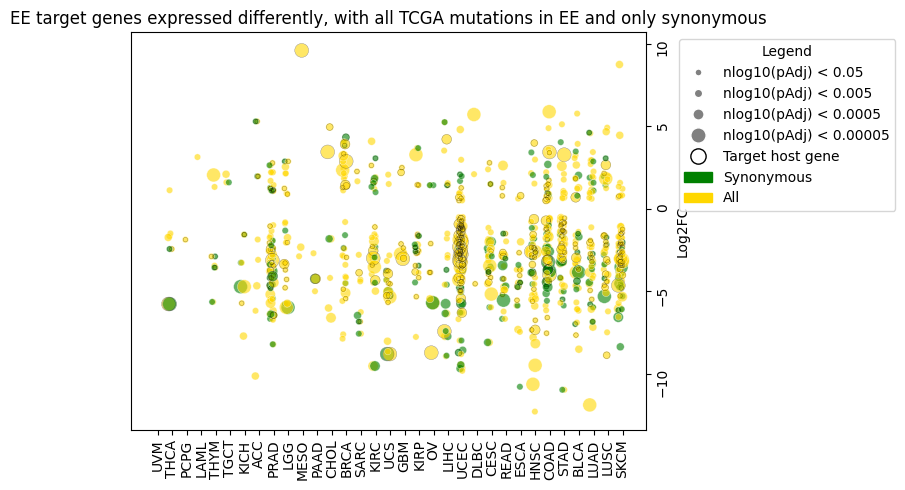

In [ ]:
### ALL IN ONE
import numpy as np

dic_gene = {}
with open("dic_gene_ee_hg38.tsv") as file:
    for line in file:    
        dic_gene[line.strip().split()[0]] = line.strip().split()[1]

color_mapping = {
    'Synonymous': 'green',
    'All': 'gold'
}

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

cat_order = ['UVM', 'THCA', 'PCPG', 'LAML', 'THYM', 'TGCT', 'KICH', 'ACC', 'PRAD',
       'LGG', 'MESO', 'PAAD', 'CHOL', 'BRCA', 'SARC', 'KIRC', 'UCS', 'GBM',
       'KIRP', 'OV', 'LIHC', 'UCEC', 'DLBC', 'CESC', 'READ', 'ESCA', 'HNSC',
       'COAD', 'STAD', 'BLCA', 'LUAD', 'LUSC', 'SKCM']

def map_size(nlog10_pvalue):
    """if nlog10_pvalue <= 1.3:
        return 20  # Smallest size"""
    if  1.3 <= nlog10_pvalue <= 2.3:
        return 20
    elif 2.3 < nlog10_pvalue <= 3.3:
        return 40
    elif 3.3 < nlog10_pvalue <= 4.3:
        return 80
    else:
        return 160  # Largest size
    
plot_data = []
for key, values in dic_result.items():
    for value in values:#log2fc,  nlog10_pvalue, categories intern_or_not
        if dic_gene[value[3]] == value[-1]:
            plot_data.append([key, value[0], map_size(value[1]), color_mapping[value[2]], True]) #cancer, log2fc,  size based on nlog10_pvalue, color based on categories, if target gene is ee host gene 
        else:
            plot_data.append([key, value[0], map_size(value[1]), color_mapping[value[2]], False])

#UVM has zero data so we had an entry just so the x ticks settles themseleves correctly
plot_data.append(["UVM",0,0,"white",False])

df_plot = pd.DataFrame(columns=["Category","Log2FC","Size","Color","Intern"],data=plot_data)

df_plot["Category"] = pd.Categorical(df_plot["Category"], cat_order)
df_plot = df_plot.sort_values("Category")
color_list = df_plot.pop("Color")

plt.figure(figsize=(8, 5))
df_plot["Category"] = pd.factorize(df_plot["Category"])[0]+np.random.random(len(df_plot))*0.3-0.3
ax = sns.scatterplot(x="Category", y="Log2FC", data=df_plot, c=color_list, size="Size", alpha=0.6, sizes=(10, 100))#, size_norm=None) #control range of the size normalization and if it is normalized 


# Add the ring for rows where 'Intern' is True
df_intern = df_plot[df_plot['Intern'] == True]  # Filter rows where Intern is True

# Plot the same points but with no fill color and larger marker size for the ring effect
ax = sns.scatterplot(x="Category", y="Log2FC", data=df_intern, facecolors='none', edgecolor='black', size="Size", alpha=0.5, sizes=(10, 100))

plt.ylabel('Log2FC')
plt.xlabel('')

plt.xticks(range(len(cat_order)), cat_order, rotation=90,fontsize=10)

legend_sizes = [
    mlines.Line2D([], [], color='w', marker='o', markersize=5, label='nlog10(pAdj) < 0.05', markerfacecolor='gray'),
    mlines.Line2D([], [], color='w', marker='o', markersize=6, label='nlog10(pAdj) < 0.005', markerfacecolor='gray'),
    mlines.Line2D([], [], color='w', marker='o', markersize=8, label='nlog10(pAdj) < 0.0005', markerfacecolor='gray'),
    mlines.Line2D([], [], color='w', marker='o', markersize=11, label='nlog10(pAdj) < 0.00005', markerfacecolor='gray'),
    mlines.Line2D([], [], color='w', marker='o', markersize=11, label='Target host gene', markerfacecolor='white',markeredgecolor="black"),
]

# Create custom legends for colors
legend_colors = [
    mpatches.Patch(color='green', label='Synonymous'),
    mpatches.Patch(color='gold', label='All')
]

# Combine legends
plt.legend(handles=legend_sizes + legend_colors, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('EE target genes expressed differently, with all TCGA mutations in EE and only synonymous')

plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position('right')
plt.gca().tick_params(axis='y', rotation=90)

plt.tight_layout()
plt.savefig("/home/mouren/Images/tls1/variants/tcga/deseq2_v2/target_genes_expressed_differently_with_scatter_intern_tight.pdf", format="pdf", bbox_inches="tight")
